## Downloading more from gisaid

- condition 
    - H6
    - Avian
    - with HA, NA, M

Isolate name |  Gene name | Type | Passage details/history| Protein Accession no. | Protein INSDC | Collection date


In [1]:
import numpy as np
import pandas as pd
import utils 
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.core.pylabtools import figsize
from Bio import SeqIO
import os
import importlib as imp

In [2]:
imp.reload(utils)

<module 'utils' from '/home/ZwZ/script/support_virus/utils.py'>

## Loading FASTA

In [3]:
data_path = '/home/ZwZ/database/M/raw/'

gisaid fasta

In [267]:
gisaid = utils.read_fasta(os.path.join(data_path,'gisaid_DK_GS.fasta'),True)
# for the convience of indexing
gisaid = np.array(gisaid)

In [268]:
columns = ['gene','id','host','subtype','seq_len']
gisaid_DF = attribute2DataFrame(columns,gisaid)

In [353]:
gisaid_DF.head()

,gene,id,host,subtype,seq_len
0,HA,EPI2969,duck,H6N2,566
1,HA,EPI3151,duck,H6N8,566
2,HA,EPI3233,duck,H6N1,566
3,HA,EPI7452,Teal,H6N1,566
4,HA,EPI9473,Mallard,H6N8,565


In [357]:
# check the order !!
np.sum(gisaid_DF.id == np.array([SeqRecord.id for SeqRecord in gisaid])),gisaid_DF.shape

(5739, (5739, 5))

### length of gene

max 252 quantile 248.0


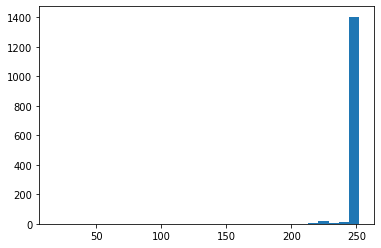

In [283]:
print('max',np.max(gisaid_DF[gisaid_DF.gene == 'M1'].seq_len),
      'quantile',np.quantile(gisaid_DF[gisaid_DF.gene == 'M1'].seq_len,0.03))

plt.hist(gisaid_DF[gisaid_DF.gene == 'M1'].seq_len,bins=30);

max 97 quantile 91.0


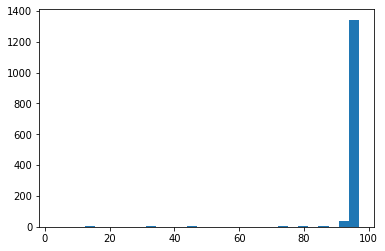

In [284]:
print('max',np.max(gisaid_DF[gisaid_DF.gene == 'M2'].seq_len),
      'quantile',np.quantile(gisaid_DF[gisaid_DF.gene == 'M2'].seq_len,0.03))

plt.hist(gisaid_DF[gisaid_DF.gene == 'M2'].seq_len,bins=30);

### after that we can do screening

In [285]:
#select M1 and M2
SeqIO.write(list(gisaid[(gisaid_DF.gene == 'M1')&(gisaid_DF.seq_len > 248)]),data_path+'gisaid_M1.fasta','fasta')

SeqIO.write(list(gisaid[(gisaid_DF.gene == 'M2')&(gisaid_DF.seq_len > 93)]),data_path+'gisaid_M2.fasta','fasta')

1365

## aligner

```shell
$ python align.py ~/database/M/M/gisaid_M1.fasta ~/database/M/M/M1_identity.npy 

$ python align.py ~/database/M/M/gisaid_M2.fasta ~/database/M/M/M2_identity.npy 
```

read in the fasta

In [401]:
del gisaid
g_M1 = np.array(read_fasta(data_path+'gisaid_M1.fasta',True))
g_M2 = np.array(read_fasta(data_path+'gisaid_M2.fasta',True))

### read identity output

In [286]:
score = aligner().score

In [287]:
# read ouput npy file
M2_identity = np.load(data_path+'M2_identity.npy')
M1_identity = np.load(data_path+'M1_identity.npy')

Text(0.5, 1.05, 'M2')

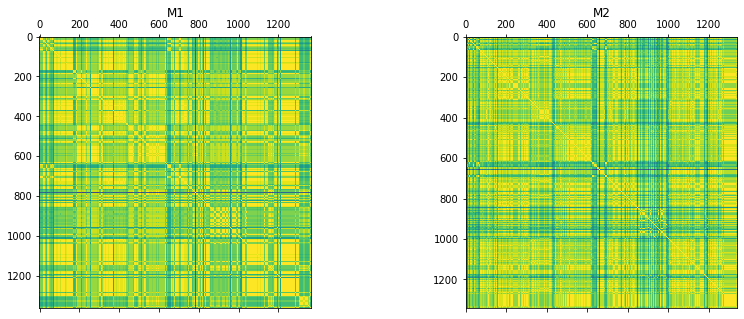

In [352]:
plt.figure(figsize=(14,5))

axis=plt.subplot(1,2,1)
axis.matshow(M1_identity)
axis.set_title("M1")

axis=plt.subplot(1,2,2)
axis.matshow(M2_identity)
axis.set_title("M2")

In [391]:
# return the n th minimum number and its index
def discard_the_less_n(fasta,identity_M,n):
    _,min_indexs=most_n(np.mean(identity_M,axis=0),n,'min')
    discard=np.unique(np.concatenate(min_indexs))
    return fasta[[i for i in range(len(fasta)) if i not in discard]]

## 2nd screen

In [402]:
# return the 4 th minimum number and its index
M1_kept=discard_the_less_n(g_M1,M1_identity,10)
M2_kept=discard_the_less_n(g_M2,M2_identity,10)

In [437]:
# to find intercepted seq
M1_DF=attribute2DataFrame(['id','host'],M1_kept)
M2_DF=attribute2DataFrame(['id','host'],M2_kept)
merged_df = M1_DF.merge(M2_DF,how='inner',right_on=['id'],left_on=['id'],indicator=True)

print(" M1 :",M1_DF.shape[0],"\n M2 :",M2_DF.shape[0],"\n intercept :",merged_df.shape[0])

 M1 : 1355 
 M2 : 1332 
 intercept : 1327


In [426]:
# implement screening 
keep_by_id = lambda fasta,List : [SeqRecord for SeqRecord in fasta if SeqRecord.id in List]

M1_clean = keep_by_id(M1_kept,merged_df.id.values)
M2_clean = keep_by_id(M2_kept,merged_df.id.values)

#### Double Check

In [450]:
array_of = lambda x,fasta : np.array([SeqRecord.__getattribute__(x) for SeqRecord in fasta])
np.sum(array_of('id',M1_clean) == array_of('id',M2_clean))

1327

In [605]:
# write
SeqIO.write(M1_clean,data_path+'M1_gisaid_clean.fasta','fasta')
SeqIO.write(M2_clean,data_path+'M2_gisaid_clean.fasta','fasta')

1327

In [445]:
del g_M1
del g_M2

## MSA by linsi
```shell
$ nohup linsi --thread -1 /home/ZwZ/database/M/raw/M1_clean.fasta > /home/ZwZ/database/M/linsi/M1_linsi.fasta &

$ nohup linsi --thread -1 /home/ZwZ/database/M/raw/M2_clean.fasta > /home/ZwZ/database/M/linsi/M2_linsi.fasta &```

## READ MSA

In [447]:
M1= read_fasta('/home/ZwZ/database/M/linsi/M1_linsi.fasta',True)
M2= read_fasta('/home/ZwZ/database/M/linsi/M2_linsi.fasta',True)

In [451]:
np.sum(array_of('id',M1) == array_of('id',M2))

1327

# PLX DK GS more

In [499]:
DK_H6_M1 = read_fasta(os.path.join(data_path,'DK_M','DK_H6_M1.fas'),True)
DK_H6_M2 = read_fasta(os.path.join(data_path,'DK_M','DK_H6_M2.fas'),True)

In [590]:
def all_gene_in_dir(gene,path,host):
    # read all the M2 file and combine into a big list, labeling host info at the same time
    fasta_ls = []
    for fasta in [item for item in os.listdir(path) if gene in item]:
        file= os.path.join(path,fasta)
        fasta_ls += read_fasta(file,True)
    for i in range(len(fasta_ls)):
        fasta_ls[i].host = host
        fasta_ls[i].description += '[host={}]'.format(host)
    return fasta_ls

In [721]:
GS_M1 = all_gene_in_dir('M1',os.path.join(data_path,'GS_M'),'Goose')
GS_M2 = all_gene_in_dir('M2',os.path.join(data_path,'GS_M'),'Goose')

In [521]:
len(GS_M1),len(GS_M2)

(547, 547)

In [529]:
GS_DF=attribute2DataFrame(['id','host','seq_len'],GS_M1).merge(attribute2DataFrame(['id','host','seq_len'],GS_M2),
                                                         how='inner',suffixes = ['_M1','_M2'],
                                                         right_on = ['id','host'],
                                                         left_on = ['id','host'])                                                        

all the sequence are the same length

In [535]:
# check length
np.sum(GS_DF.seq_len_M1 == 759),np.sum(GS_DF.seq_len_M2 == 279)

(547, 547)

In [722]:
for i in range(len(GS_M1)):
    GS_M1[i].seq=GS_M1[i].seq.translate()[:-1]
    GS_M1[i].seq_len=len(GS_M1[i])
for i in range(len(GS_M2)):
    GS_M2[i].seq=GS_M2[i].seq.translate()
    GS_M2[i].seq_len=len(GS_M2[i])

### DK

In [723]:
DK_M1=read_fasta(os.path.join(data_path,'DK_M','DK_H6_M1.fas'),True)
DK_M2=read_fasta(os.path.join(data_path,'DK_M','DK_H6_M2.fas'),True)

In [724]:
for i in range(len(DK_M1)):
    DK_M1[i].host = 'Duck'
    DK_M1[i].description += '[host=Duck]'
for i in range(len(DK_M2)):
    DK_M2[i].host = 'Duck'
    DK_M2[i].description += '[host=Duck]'

In [725]:
for i in range(len(DK_M1)):
    aa = de_alignment(DK_M1[i].seq).translate()[:-1]
    if '*' not in aa:
        DK_M1[i].seq=aa[:-1]
        DK_M1[i].seq_len=len(DK_M1[i])
    else:
        print(i)

144


/home/ZwZ/anaconda3/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [726]:
for i in range(len(DK_M2)):
    aa = de_alignment(DK_M2[i].seq).translate()[:-1]
    if '*' not in aa:
        DK_M2[i].seq=aa[:-1]
        DK_M2[i].seq_len=len(DK_M2[i])
    else:
        print(i)

In [727]:
DK_M1 = [DK_M1[i] for i in range(len(DK_M1)) if i != 144]
DK_M2 = [DK_M2[i] for i in range(len(DK_M2)) if i != 144]

In [728]:
DK_DF=attribute2DataFrame(['id','host','seq_len'],DK_M1).merge(attribute2DataFrame(['id','host','seq_len'],DK_M2),
                                                         how='inner',suffixes = ['_M1','_M2'],
                                                         right_on = ['id','host'],
                                                         left_on = ['id','host'])                                                        

In [729]:
len(DK_M1),len(DK_M2),DK_DF.shape[0]

(310, 310, 310)

# ALL THE SEQUENCE

In [730]:
M1_all=M1_clean + GS_M1 + DK_M1

M2_all=M2_clean + GS_M2 + DK_M2

SeqIO.write(M1_all,os.path.join(data_path,'M1_all.fasta'),'fasta')

SeqIO.write(M2_all,os.path.join(data_path,'M2_all.fasta'),'fasta')

2184

In [731]:
M1_M = np.load(os.path.join(data_path,'M1_all.npy'))
for i in range(M1_M.shape[0]):
    M1_M[i,i] = np.nan
M2_M = np.load(os.path.join(data_path,'M2_all.npy'))
for i in range(M2_M.shape[0]):
    M2_M[i,i] = np.nan

In [732]:
0.98939393 == 1

False

/home/ZwZ/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/ZwZ/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


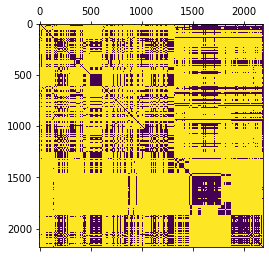

In [733]:
plt.matshow((M2_M > 0.9)&(M2_M <0.98))

In [734]:
def drop_identical(matrix):
    identical = []

    for i in range(matrix.shape[0]):
        identical.append(np.where(matrix[i,:]==1)[0])

    keep = []

    for list in identical:
        if len(list) > 0:
            keep.append(list[0])

    return np.unique(keep),identical

In [735]:
idex = lambda List,discard : [i for i in range(len(List)) if i not in discard]

&nbsp;    
  
**<center> <font size=7 color='navy'> |------>> SAVE CLEAN M1 AND M2 <<------|**  
    &nbsp;

In [774]:
# M1
keep,identical = drop_identical(M1_M)
M1 = np.array(M1_all)[keep]
SeqIO.write(np.array(M1_all)[keep],os.path.join(data_path,'M1_all_clean.fasta'),'fasta')
# M2
keep,identical = drop_identical(M2_M)
M2 = np.array(M2_all)[keep]
SeqIO.write(np.array(M2_all)[keep],os.path.join(data_path,'M2_all_clean.fasta'),'fasta')

193

In [790]:
columns = ['id','name','host','seq_len','date','subtype']
clean_DF = attribute2DataFrame(columns,M1).merge(attribute2DataFrame(columns,M2),how='right',
                                                right_on=['id','name','host','subtype','date'],
                                                left_on = ['id','name','host','subtype','date'],
                                                suffixes=['_M1','_M2'],indicator=True)

In [791]:
clean_DF.seq

,id,name,host,seq_len_M1,date,subtype,seq_len_M2,_merge
0,EPI22345,EPI22345 A/mallard/Alberta/98/85,mallard,252.0,85,H6N2,97,both
1,EPI22361,EPI22361 A/pintail/Alberta/113/85,pintail,252.0,85,H6N2,97,both
2,EPI33840,EPI33840 A/mallard/Maryland/881/2002,mallard,252.0,2002,H6N2,97,both
3,EPI40336,EPI40336 A/green-winged teal/Ohio/178/1999,green-winged teal,252.0,1999,H6N2,97,both
4,EPI45717,EPI45717 A/green-winged teal/Ohio/59/1989,green-winged teal,252.0,1989,H6N8,97,both
...,...,...,...,...,...,...,...,...
216,CIR026180,Gs/Huizhou/3119/2017,Goose,NaN,2017,H6N2,93,right_only
217,CIR028977,Gs/Huizhou/1837/2018,Goose,NaN,2018,H6N2,93,right_only
218,CIR028978,Gs/Huizhou/1848/2018,Goose,NaN,2018,H6N2,93,right_only
219,CIR034008,Gs/ST/2611/2012,Goose,NaN,2012,H6N2,93,right_only


## delve into the detail of identical gene

In [792]:
# the biggest group of identical sequences
M2_all_DF=attribute2DataFrame(['id','name','host','seq_len','date'],M2_all)
M2_all_DF.iloc[identical[1874],:].to_csv(data_path+'M2_bigGroup.csv',index=None)
np.argmax([len(List) for List in identical])

1875

In [753]:
# isolate the sequence of the biggest group and save to fasta
bigGroup=np.array(M2_all)[identical[1874]]
SeqIO.write(bigGroup,data_path+'M2_bigGroup.fasta','fasta')

100%|██████████| 485/485 [00:09<00:00, 49.62it/s]


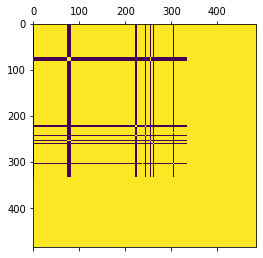

In [794]:
import align
# directly align here
big_I = align.identity(bigGroup)
plt.matshow(big_I==1)

In [12]:
path = '/home/ZwZ/database/M/linsi'

In [112]:
M1_all=utils.read_fasta(os.path.join(path,'M1_all_linsi.fasta'),True)

M2_all=utils.read_fasta(os.path.join(path,'M2_all_linsi.fasta'),True)

In [4]:
from Bio import Seq

In [114]:
con = []
for i,SeqRecord in enumerate(M1_all):
    for Seq2 in M2_all:
        if SeqRecord.id == Seq2.id :
            SeqRecord.seq = Seq.Seq(SeqRecord.seq.__str__().replace('\n','')+Seq2.seq.__str__())
            SeqRecord.description = SeqRecord.description.replace('M1','M1+M2')
            con.append(SeqRecord)

In [115]:
SeqIO.write(con,os.path.join(path,'M1_M2_all.fasta'),'fasta')

2184

In [116]:
len_check=np.array([len(SeqRecord.seq) for SeqRecord in con])

In [117]:
len_check

array([349, 349, 349, ..., 349, 349, 349])

```shell
$ nohup ~/software/iqtree-1.6.12-Linux/bin/iqtree -s M1_M2_all.fasta -nt AUTO -bb 1000 -m MFP&```

## Unique phy

In [6]:
path = '/home/ZwZ/database/M/linsi/'

In [95]:
file = os.path.join('/home/ZwZ/database/M/','tree','M1_M2_all.fasta.uniqueseq.phy')

In [124]:
with open(file) as f:
    unique=f.readlines()[1:]
    f.close()

In [155]:
unique = [item.split(' ')[0] for item in unique]

In [156]:
unique

['EPI7458',
 'EPI12210',
 'EPI22345',
 'EPI22361',
 'EPI25831',
 'EPI33840',
 'EPI40336',
 'EPI42760',
 'EPI42914',
 'EPI44083',
 'EPI45679',
 'EPI45698',
 'EPI45717',
 'EPI46727',
 'EPI49430',
 'EPI52126',
 'EPI58944',
 'EPI59020',
 'EPI59039',
 'EPI59058',
 'EPI59077',
 'EPI59096',
 'EPI59115',
 'EPI59400',
 'EPI59894',
 'EPI60559',
 'EPI60821',
 'EPI68277',
 'EPI85494',
 'EPI85540',
 'EPI85557',
 'EPI85773',
 'EPI85809',
 'EPI85828',
 'EPI85850',
 'EPI85869',
 'EPI85983',
 'EPI86040',
 'EPI86059',
 'EPI86097',
 'EPI86116',
 'EPI89371',
 'EPI89597',
 'EPI102033',
 'EPI102060',
 'EPI102066',
 'EPI102114',
 'EPI102117',
 'EPI102126',
 'EPI117913',
 'EPI119109',
 'EPI120130',
 'EPI137811',
 'EPI154556',
 'EPI154604',
 'EPI154819',
 'EPI158374',
 'EPI167062',
 'EPI167070',
 'EPI178753',
 'EPI178761',
 'EPI221455',
 'EPI221487',
 'EPI221519',
 'EPI222179',
 'EPI231014',
 'EPI231022',
 'EPI231030',
 'EPI231038',
 'EPI231046',
 'EPI231054',
 'EPI231062',
 'EPI231078',
 'EPI231086',
 'EPI231

In [134]:
con = []
for i,SeqRecord in enumerate(M1_all):
    for Seq2 in M2_all:
        if SeqRecord.id == Seq2.id :
            SeqRecord.seq = Seq.Seq(SeqRecord.seq.__str__().replace('\n','')+Seq2.seq.__str__())
            SeqRecord.description = SeqRecord.description.replace('M1','M1+M2')
            con.append(SeqRecord)

733

In [163]:
for i in range(len(con)):
    if (' ' in con[i].id): 
        ids = con[i].id.split(' ')
        if ids[0] == ids[1]:
            con[i].id = ids[0]

In [164]:
u_fasta = [SeqRecord for SeqRecord in con if SeqRecord.id in unique]

In [165]:
len(u_fasta)

733

In [168]:
SeqIO.write(u_fasta,os.path.join(path,'M1_M2_unique.fasta'),'fasta')

733

In [8]:
u_fasta=utils.read_fasta(os.path.join(path,'M1_M2_unique.fasta'),True)

In [10]:
u_fasta[13].seq

Seq('MSLLTEVETYVLSIIPSGPLKAEIAQRLEDVFAGKNTDLEALMEWLKTRPILSP...EL-', SingleLetterAlphabet())

In [14]:
score = utils.aligner().score

In [23]:
score(u_fasta[0].seq,u_fasta[13].seq.__str__().replace('-',''))

ValueError: sequence contains letters not in the alphabet

In [20]:
print(utils.aligner())

Pairwise sequence aligner with parameters
  match_score: 1.000000
  mismatch_score: 0.000000
  target_internal_open_gap_score: 0.000000
  target_internal_extend_gap_score: 0.000000
  target_left_open_gap_score: 0.000000
  target_left_extend_gap_score: 0.000000
  target_right_open_gap_score: 0.000000
  target_right_extend_gap_score: 0.000000
  query_internal_open_gap_score: 0.000000
  query_internal_extend_gap_score: 0.000000
  query_left_open_gap_score: 0.000000
  query_left_extend_gap_score: 0.000000
  query_right_open_gap_score: 0.000000
  query_right_extend_gap_score: 0.000000
  mode: global

